# <center> Проект_5: Задача регрессии

Импорт необходимых библиотек:

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from scipy.stats import normaltest
from scipy.stats import mannwhitneyu
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import median_absolute_error
from sklearn import cluster
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge


data = 'C:/Users/admin/Desktop/FDSupportBK/my_projects_DST120/edu_projects/project_5_regrassion/Project5_train_data/train.csv'
holiday = 'C:/Users/admin/Desktop/FDSupportBK/my_projects_DST120/edu_projects/project_5_regrassion/holiday_data.csv'
osrm = 'C:/Users/admin/Desktop/FDSupportBK/my_projects_DST120/edu_projects/project_5_regrassion/osrm_data_train.csv'
weather = 'C:/Users/admin/Desktop/FDSupportBK/my_projects_DST120/edu_projects/project_5_regrassion/weather_data.csv'
test_data = 'C:/Users/admin/Desktop/FDSupportBK/my_projects_DST120/edu_projects/project_5_regrassion/test_data.csv'
osrm_data_test = 'C:/Users/admin/Desktop/FDSupportBK/my_projects_DST120/edu_projects/project_5_regrassion/osrm_data_test.csv'

## Часть 1. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 

Прочитаем наш файл с исходными данными:

In [10]:
taxi_data = pd.read_csv(data)
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Условно разделим признаки на нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

**1.1** Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведем признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определим временные рамки (без учета времени), за которые представлены данные.

In [11]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

min_date = taxi_data['pickup_datetime'].min().date()
max_date = taxi_data['pickup_datetime'].max().date()

print("Минимальная дата:", min_date)
print("Максимальная дата:", max_date)

Минимальная дата: 2016-01-01
Максимальная дата: 2016-06-30


**1.2** Посмотрим на пропуски. Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы).

In [12]:
print(taxi_data.isnull().sum().sum())

0


**1.3**
Посмотрим на статистические характеристики некоторых признаков: 

а) Сколько уникальных таксопарков присутствует в данных;

б) Каково максимальное количество пассажиров;

в) Чему равна средняя и медианная длительность поездки (в секундах с округлением до целого);

г) Чему равно минимальное и максимальное время поездки (в секундах).

In [13]:
#taxi_data.describe().round()
#taxi_data['vendor_id'].unique()
print("Кол-во уникальных таксопарков:", taxi_data['vendor_id'].nunique())
print("Максимальное кол-во пассажиров:", taxi_data['passenger_count'].max())
print("Средняя длительность поездки:", round(taxi_data['trip_duration'].mean()), "Медианная длительность поездки:", round(taxi_data['trip_duration'].median()))
print("Минимальное время поездки:", taxi_data['trip_duration'].min(), "Максимальное время поездки:", taxi_data['trip_duration'].max())

Кол-во уникальных таксопарков: 2
Максимальное кол-во пассажиров: 9
Средняя длительность поездки: 959 Медианная длительность поездки: 662
Минимальное время поездки: 1 Максимальное время поездки: 3526282


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


**1.4**
Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу;

б) Сколько поездок в среднем совершается в день (округлим до целого).

In [14]:
def add_datetime_features(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()

    return df

taxi_data = add_datetime_features(taxi_data)

saturday_trips = taxi_data[taxi_data['pickup_day_of_week'] == 'Saturday'].shape[0]
print('Кол-во поездок в субботу:', saturday_trips)

average_trip_per_day = taxi_data.groupby('pickup_date').size().mean()
print("Среднее кол-во поездок в день:", round(average_trip_per_day))

Кол-во поездок в субботу: 220868
Среднее кол-во поездок в день: 8015


**1.5**
Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни (в секундах, с округлением до целого).


In [15]:
holiday_data = pd.read_csv(holiday, sep=';')

def add_holiday_features(df, holiday_df):
    holiday_df['date'] = pd.to_datetime(holiday_df['date']).dt.date
    df = df.merge(holiday_df, left_on='pickup_date', right_on='date', how='left')
    #df['pickup_holiday'] = holiday_df['date'].notnull().astype(int)
    df['pickup_holiday'] = df['holiday'].fillna(0)
    df['pickup_holiday'] = df['pickup_holiday'].apply(lambda x: 0 if x == 0 else 1)
    
    return df
    
taxi_data = add_holiday_features(taxi_data, holiday_data)
median_duration_holiday = taxi_data.loc[taxi_data['pickup_holiday'] == 1, 'trip_duration'].median()
taxi_data = taxi_data.drop(['day', 'date', 'holiday'], axis=1)
print(round(median_duration_holiday))
#taxi_data.head()

585


**1.6**
Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM;

В результате объединения таблиц у нас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц.

In [16]:
osrm_data = pd.read_csv(osrm)

def add_osrm_features(df, osrm_df):
    osrm_features = ['id','total_distance','total_travel_time','number_of_steps']
    df = df.merge(osrm_df[osrm_features], on = 'id', how = 'left')
    
    return df

taxi_data = add_osrm_features(taxi_data, osrm_data)

taxi_data_difference = round(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median())
print(taxi_data_difference)
print(taxi_data.isna().sum().max())

372
1


In [17]:
# Для вычисления расстояния Хаверсина между двумя точками на сфере
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# Для вычисления угла направления между точками
def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

**1.7**
Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах с округлением до целого).


In [18]:
def add_geographical_features(df):
    lat1, lat2 = df['pickup_latitude'].values, df['dropoff_latitude'].values
    lng1, lng2 = df['pickup_longitude'].values, df['dropoff_longitude'].values
    
    # Добавление столбца haversine_distance
    df['haversine_distance'] = get_haversine_distance(lat1, lng1, lat2, lng2)

    # Добавление столбца direction
    df['direction'] = get_angle_direction(lat1, lng1, lat2, lng2)

    return df

taxi_data = add_geographical_features(taxi_data)

print("Медианное расстояние Хаверсина поездок:", np.round(taxi_data['haversine_distance'].median(), 2), "км")

Медианное расстояние Хаверсина поездок: 2.09 км


**1.8**
Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере.


In [19]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
cluster_model = cluster.KMeans(n_clusters=10, random_state=42)
cluster_model.fit(coords)


def add_cluster_features(df, cluster_model):
    destinations = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]

    # Присваивание географических кластеров
    clusters = cluster_model.predict(destinations.values)

    # Добавление столбца с географическими кластерами в исходную таблицу
    df['geo_cluster'] = clusters

    return df

taxi_data = add_cluster_features(taxi_data, cluster_model)
# Сколько поездок содержится в наименьшем по размеру географическом кластере?
print(taxi_data['geo_cluster'].value_counts().min())

C:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


**1.9**
Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду;

В результате объединения у нас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями (округлим до сотых процента).


In [20]:
weather_data = pd.read_csv(weather)


def add_weather_features(df, weather_df):
    weather_df['time'] = pd.to_datetime(weather_df['time'])
    weather_df['date'] = weather_df['time'].dt.date
    weather_df['hour'] = weather_df['time'].dt.hour
      
    # Выбор необходимых столбцов таблицы weather_data
    weather_features = ['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']
    df = df.merge(weather_df[weather_features], left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'], how='left')
    #df = df.drop(['date', 'hour'], axis=1)
    
    return df

taxi_data = add_weather_features(taxi_data, weather_data)

print("Кол-во поездок в снежную погоду:", len(taxi_data[taxi_data['events'] == 'Snow']))

missing_values = taxi_data.isnull().sum().max()
missing_percentage = missing_values / taxi_data.shape[0] * 100
missing_percentage = round(missing_percentage, 2)

print("Процент пропусков в столбцах с погодными условиями:", missing_percentage, "%")

Кол-во поездок в снежную погоду: 13126
Процент пропусков в столбцах с погодными условиями: 0.82 %


**1.10**
Реализуем функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков (округлим до десятых).


In [21]:
def fill_null_weather_data(df):
    #Заполняю пропуски в стодбцах с погодными условиями
    weather_features = ['temperature', 'visibility', 'wind speed', 'precip']
    df[weather_features] = df.groupby('pickup_date')[weather_features].transform(lambda x: x.fillna(x.median()))
    df['events'] = df['events'].fillna('None')
    
    osrm_features = ['total_distance','total_travel_time','number_of_steps']
    df[osrm_features] = df[osrm_features].fillna(df[osrm_features].median())
    
    return df

taxi_data = fill_null_weather_data(taxi_data)

# Расчет медианы в столбце temperature после заполнения пропусков

print("Медиана после заполнения пропусков:", round(taxi_data['temperature'].median(), 1))

Медиана после заполнения пропусков: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


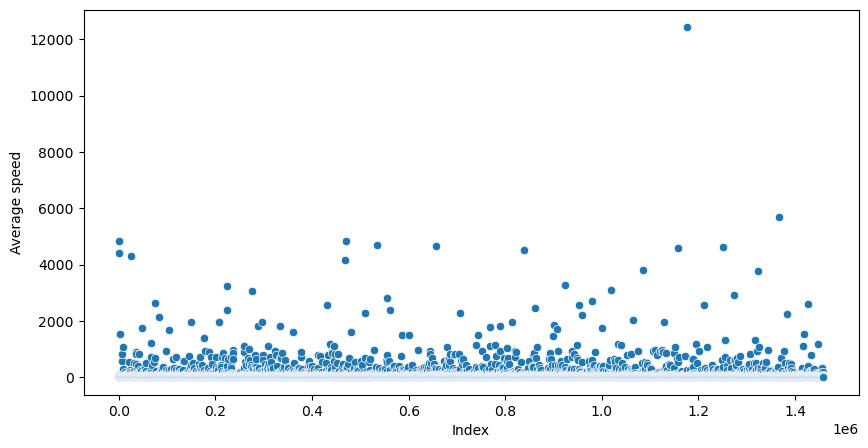

In [22]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более **12000 км/ч**! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


**1.11**
Найдем поездки, длительность которых превышает 24 часа и удалим их из набора данных.

а) Сколько выбросов по признаку длительности поездки нам удалось найти;

Найдем поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалим их из данных. 

б) Сколько выбросов по признаку скорости нам удалось найти.

In [23]:
# Поиск выбросов по признаку длительности поездки
taxi_data['trip_duration_hours'] = taxi_data['trip_duration'] / 3600
outliers_duration = taxi_data[taxi_data['trip_duration_hours'] > 24].index
taxi_data.drop(outliers_duration, inplace = True)
print("Кол-во выбросов по признаку длительности поездки:", len(outliers_duration))

# Поиск выбросов по признаку скорости
taxi_data['average_speed_kmh'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
outliers_speed = taxi_data[taxi_data['average_speed_kmh'] > 300].index
taxi_data.drop(outliers_speed, inplace = True)
print("Кол-во выбросов по признаку скорости:", len(outliers_speed))

Кол-во выбросов по признаку длительности поездки: 4
Кол-во выбросов по признаку скорости: 407


## Часть 2. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими исследование.

Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [28]:
#taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)
trip_duration = taxi_data['trip_duration']
trip_duration_log = np.log(trip_duration+1)


**2.1**
Построем гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделаем предположение, является ли полученное распределение нормальным? 
Проверим свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value (округлим до сотых);

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным.

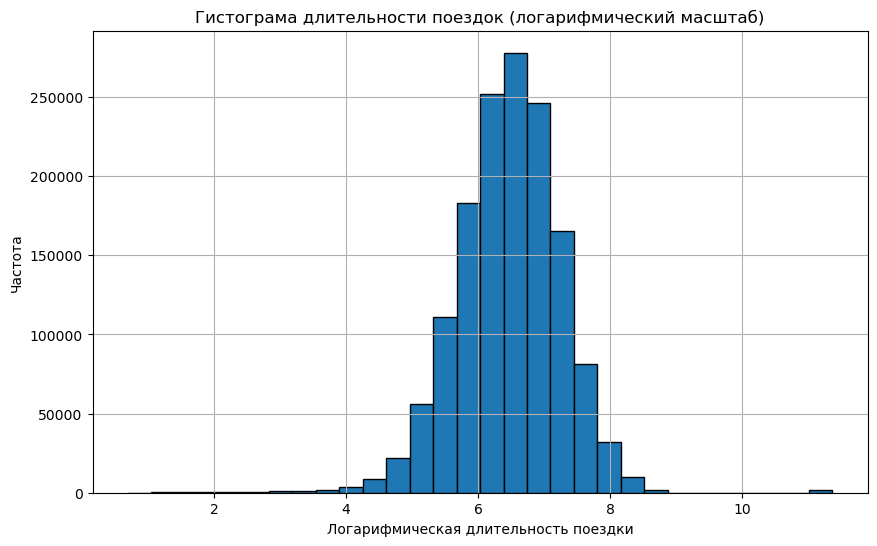

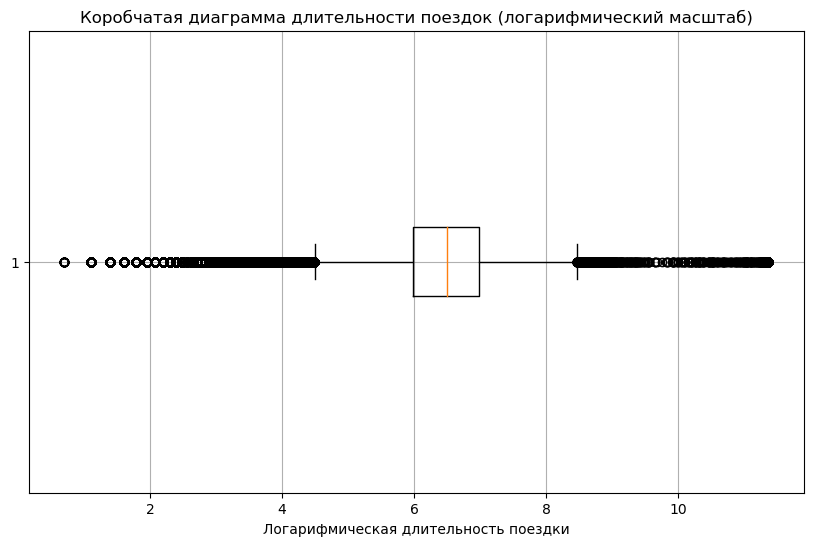

p_value = 0.000
Вывод: Распределение длительности поездок в лог масштабе может быть нормальным


In [29]:
# Построение гистограммы
plt.figure(figsize=(10,6))
plt.hist(taxi_data['trip_duration_log'], bins=30, edgecolor='black')
plt.xlabel('Логарифмическая длительность поездки')
plt.ylabel('Частота')
plt.title('Гистограма длительности поездок (логарифмический масштаб)')
plt.grid(True)
plt.show()

# Построение коробчатой диаграммы
plt.figure(figsize=(10,6))
plt.boxplot(taxi_data['trip_duration_log'], vert=False)
plt.xlabel('Логарифмическая длительность поездки')
plt.title('Коробчатая диаграмма длительности поездок (логарифмический масштаб)')
plt.grid(True)
plt.show()

# Предполагаю, что распределение данных близко к нормальному
# Проверим свою гипотезу с помощью теста Д’Агостино при уровне значимости  𝛼lpha=0.05


alpha = 0.05 # Уровень значимости
statistic, p_value = normaltest(trip_duration_log)
print("p_value = {:.3f}".format(p_value))

if p_value > alpha:
    print("Вывод: Распределение длительности поездок в лог масштабе не является нормальным")
else:
    print("Вывод: Распределение длительности поездок в лог масштабе может быть нормальным")

**2.2**
Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравним два распределения между собой.

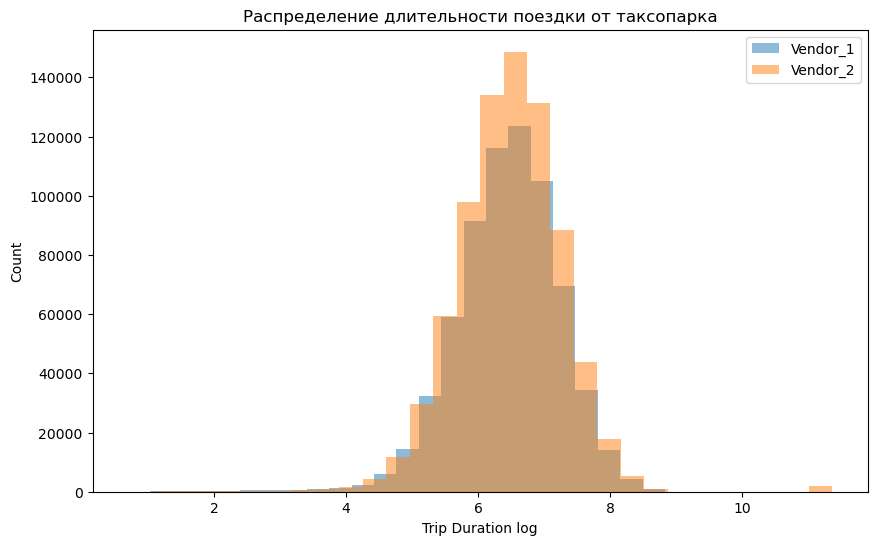

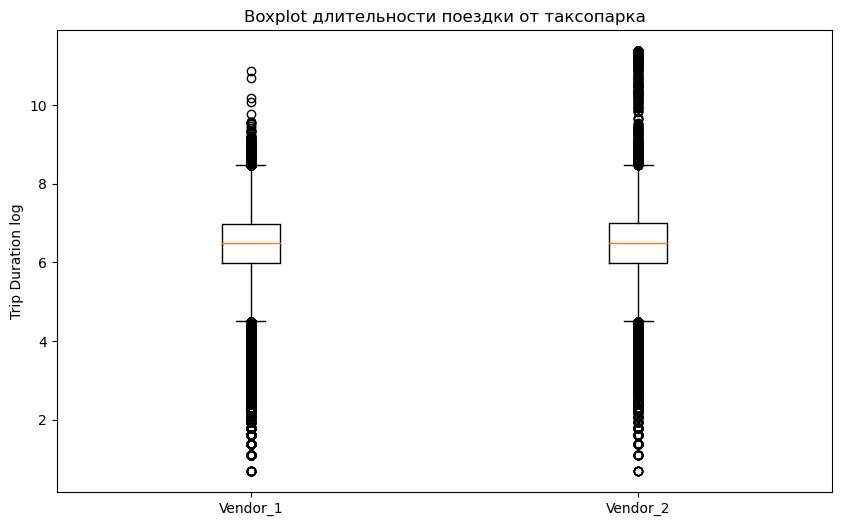

Вывод: Нет статистически значимых различий между распределениями


In [30]:
# Разделение данных по таксопаркам
vendor_1 = taxi_data[taxi_data['vendor_id'] == 1]['trip_duration_log']
vendor_2 = taxi_data[taxi_data['vendor_id'] == 2]['trip_duration_log']

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.hist(vendor_1, bins=30, alpha=0.5, label='Vendor_1')
plt.hist(vendor_2, bins=30, alpha=0.5, label='Vendor_2')
plt.xlabel('Trip Duration log')
plt.ylabel('Count')
plt.title('Распределение длительности поездки от таксопарка')
plt.legend()
plt.show()

# Построение коробчатой диаграммы
plt.figure(figsize=(10, 6))
plt.boxplot([vendor_1, vendor_2], labels=['Vendor_1', 'Vendor_2'])
plt.ylabel('Trip Duration log')
plt.title('Boxplot длительности поездки от таксопарка')
plt.show()



# Для сравнения двух распределений воспользуемся тестом Стьюдента при уровне значимости  𝛼lpha=0.05

alpha = 0.05 # Уровень значимости

t_statistic, p_value = stats.ttest_ind(vendor_1, vendor_2)


if p_value > alpha:
    print("Вывод: Есть статистически значимые различия между распределениями")
else:
    print("Вывод: Нет статистически значимых различий между распределениями")

**2.3**
Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравним два распределения между собой.

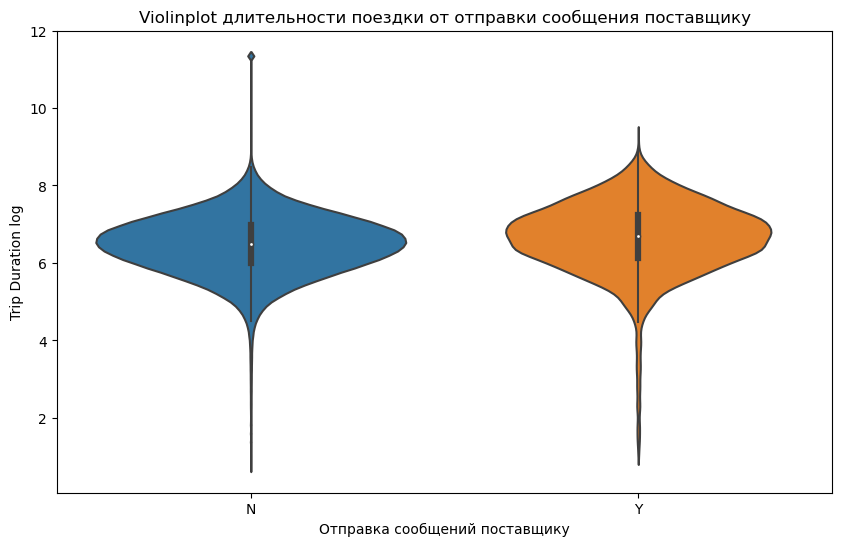

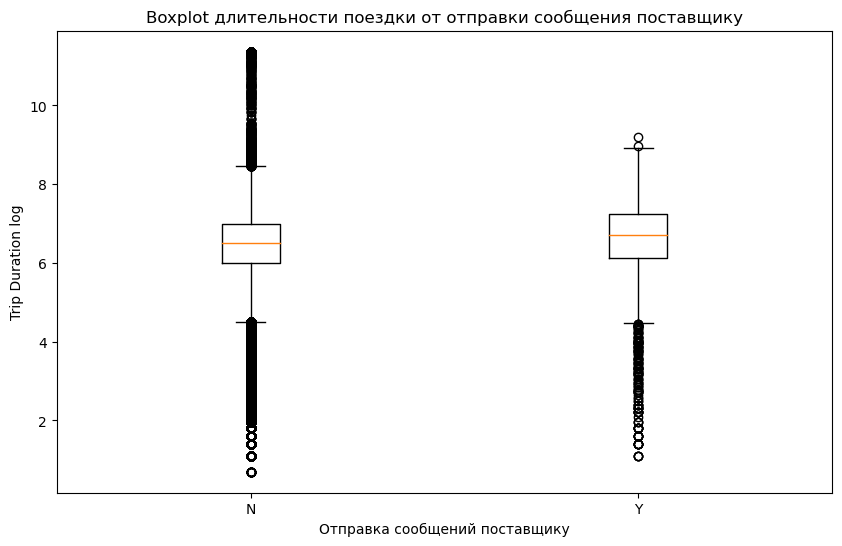

In [31]:
# Сгруппируем данные по категориям признака "store_and_fwd_flag"
grouped_data = taxi_data.groupby('store_and_fwd_flag')

# Построим violinplot диаграмму для каждой категории
plt.figure(figsize=(10, 6))
sns.violinplot(data=taxi_data, x='store_and_fwd_flag', y='trip_duration_log')
plt.xlabel('Отправка сообщений поставщику')
plt.ylabel('Trip Duration log')
plt.title('Violinplot длительности поездки от отправки сообщения поставщику')
plt.show()

# Построим коробчатую диаграмму для каждой категории
plt.figure(figsize=(10, 6))
plt.boxplot([group['trip_duration_log'] for flag, group in grouped_data])
plt.xlabel('Отправка сообщений поставщику')
plt.ylabel('Trip Duration log')
plt.title('Boxplot длительности поездки от отправки сообщения поставщику')
plt.xticks(range(1, len(grouped_data.groups) + 1), grouped_data.groups.keys())
plt.show()



**2.4**
Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответим на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

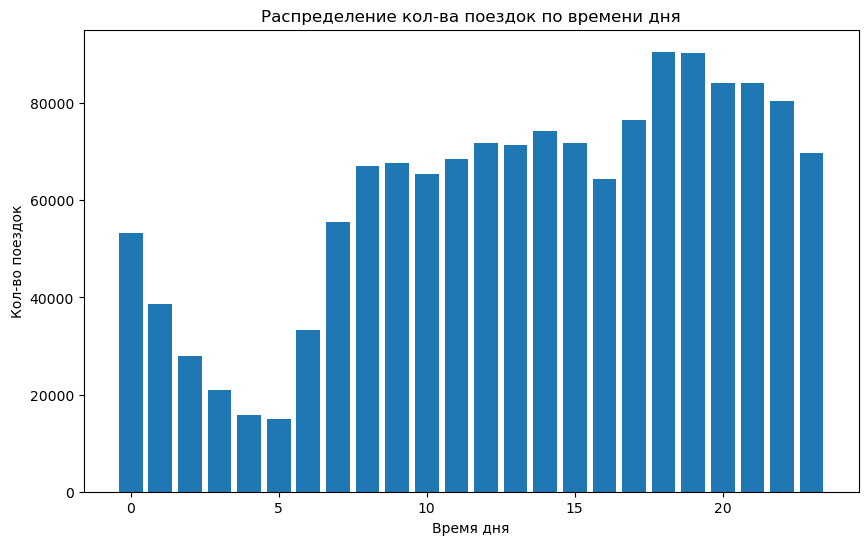

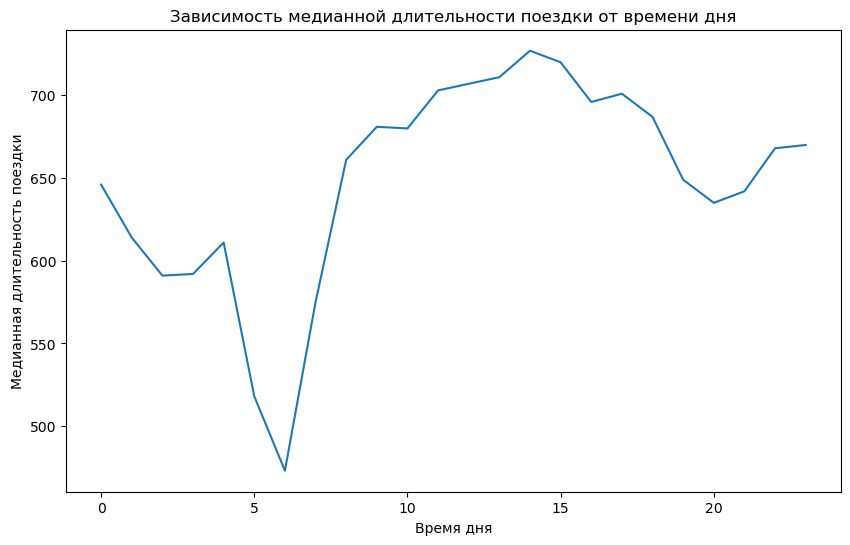

In [32]:

# Cгруппируем данные по времени дня и подсчитаем количество поездок
trips_by_hour = taxi_data.groupby(taxi_data['pickup_hour'])['trip_duration'].count()

# Создадим столбчатую диаграмму
plt.figure(figsize=(10, 6))
plt.bar(trips_by_hour.index, trips_by_hour.values)
plt.xlabel('Время дня')
plt.ylabel('Кол-во поездок')
plt.title('Распределение кол-ва поездок по времени дня')
plt.show()

# Cгруппируем данные по времени дня и вычислим медианную длительность поездки
median_duration_by_hour = taxi_data.groupby(taxi_data['pickup_hour'])['trip_duration'].median()

# Создадим график
plt.figure(figsize=(10, 6))
plt.plot(median_duration_by_hour.index, median_duration_by_hour.values)
plt.xlabel('Время дня')
plt.ylabel('Медианная длительность поездки')
plt.title('Зависимость медианной длительности поездки от времени дня')
plt.show()

**2.5**
Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответим на следующие вопросы:

а) В какой день недели совершается больше всего поездок?

б) В какой день недели медианная длительность поездок наименьшая?

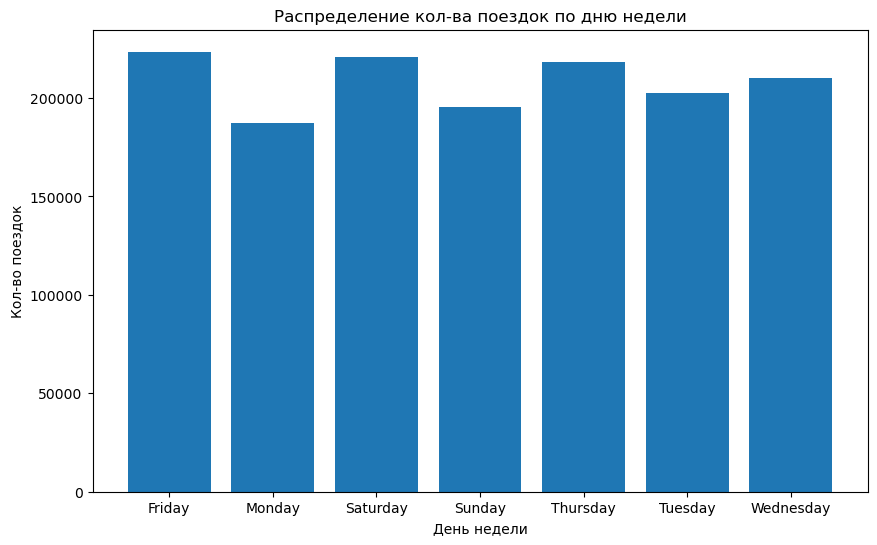

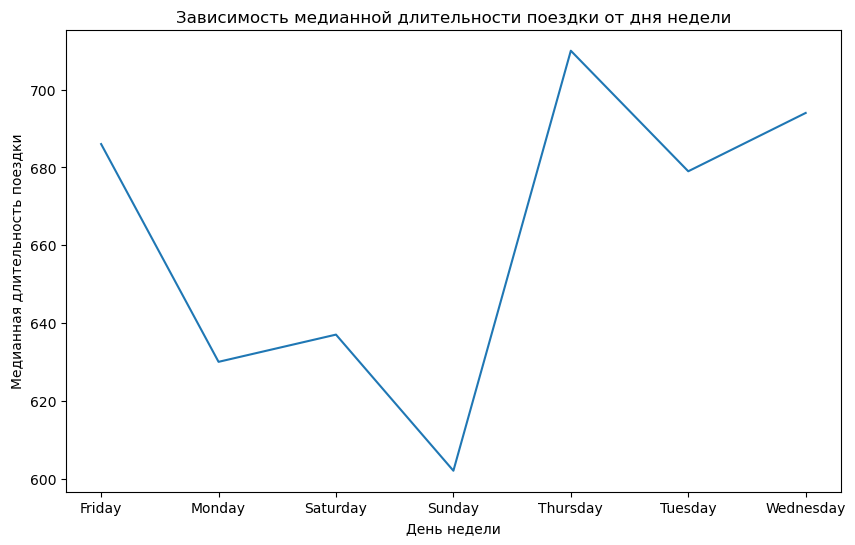

In [33]:
# Cгруппируем данные по дню недели и подсчитаем количество поездок
trips_by_day = taxi_data.groupby(taxi_data['pickup_day_of_week'])['trip_duration'].count()

# Создадим столбцатую диаграмму
plt.figure(figsize=(10, 6))
plt.bar(trips_by_day.index, trips_by_day.values)
plt.xlabel('День недели')
plt.ylabel('Кол-во поездок')
plt.title('Распределение кол-ва поездок по дню недели')
plt.show()


# Cгруппируем данные по дню недели и вычислим медианную длительность поездки
median_duration_by_day = taxi_data.groupby(taxi_data['pickup_day_of_week'])['trip_duration'].median()

# Создадим график
plt.figure(figsize=(10, 6))
plt.plot(median_duration_by_day.index, median_duration_by_day.values)
plt.xlabel('День недели')
plt.ylabel('Медианная длительность поездки')
plt.title('Зависимость медианной длительности поездки от дня недели')
plt.show()

**2.6**
Посмотрим на обе временные характеристики одновременно. 

Построим сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируем полученную сводную таблицу с помощью тепловой карты.

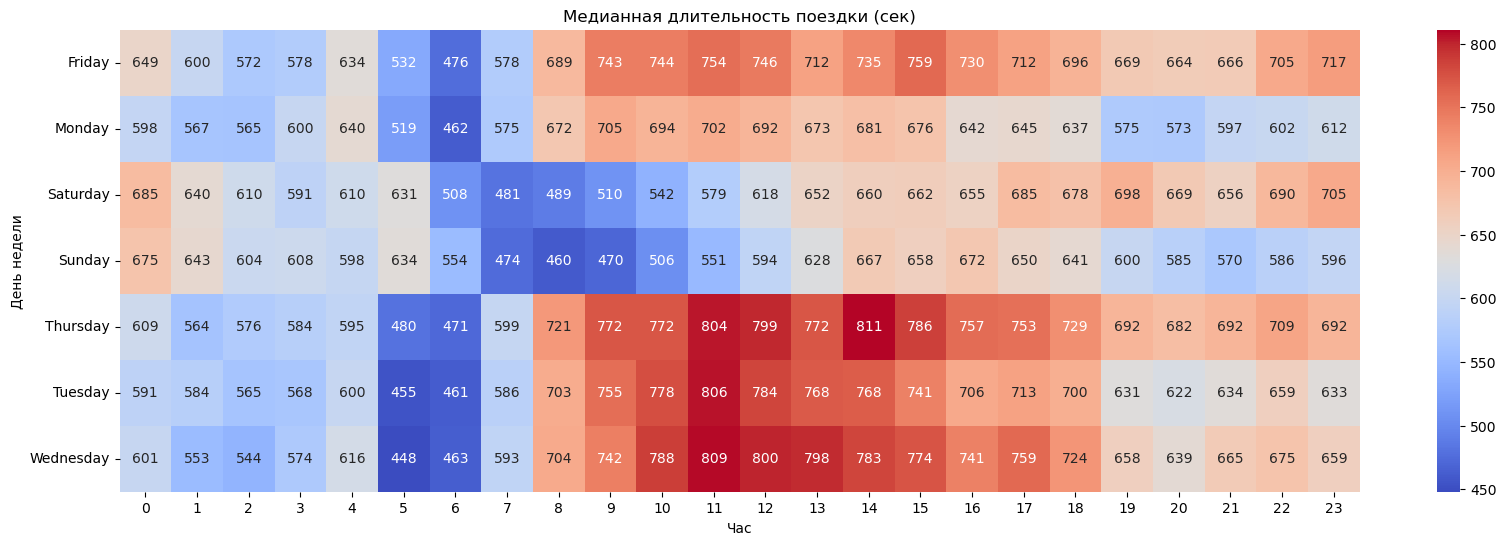

In [34]:
# Создаем сводную таблицу
pivot_table = pd.pivot_table(taxi_data, values='trip_duration', index='pickup_day_of_week', columns='pickup_hour', aggfunc='median')

#print(pivot_table)

# Создаем тепловую карту
plt.figure(figsize=(20, 6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='.0f')

# Создаем график
plt.xlabel('Час')
plt.ylabel('День недели')
plt.title('Медианная длительность поездки (сек)')
plt.show()

**2.7**
Построим две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложим широту (longitude), а по оси ординат - долготу (latitude). 
Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавим следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавим на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшим размер точек на диаграмме рассеяния.


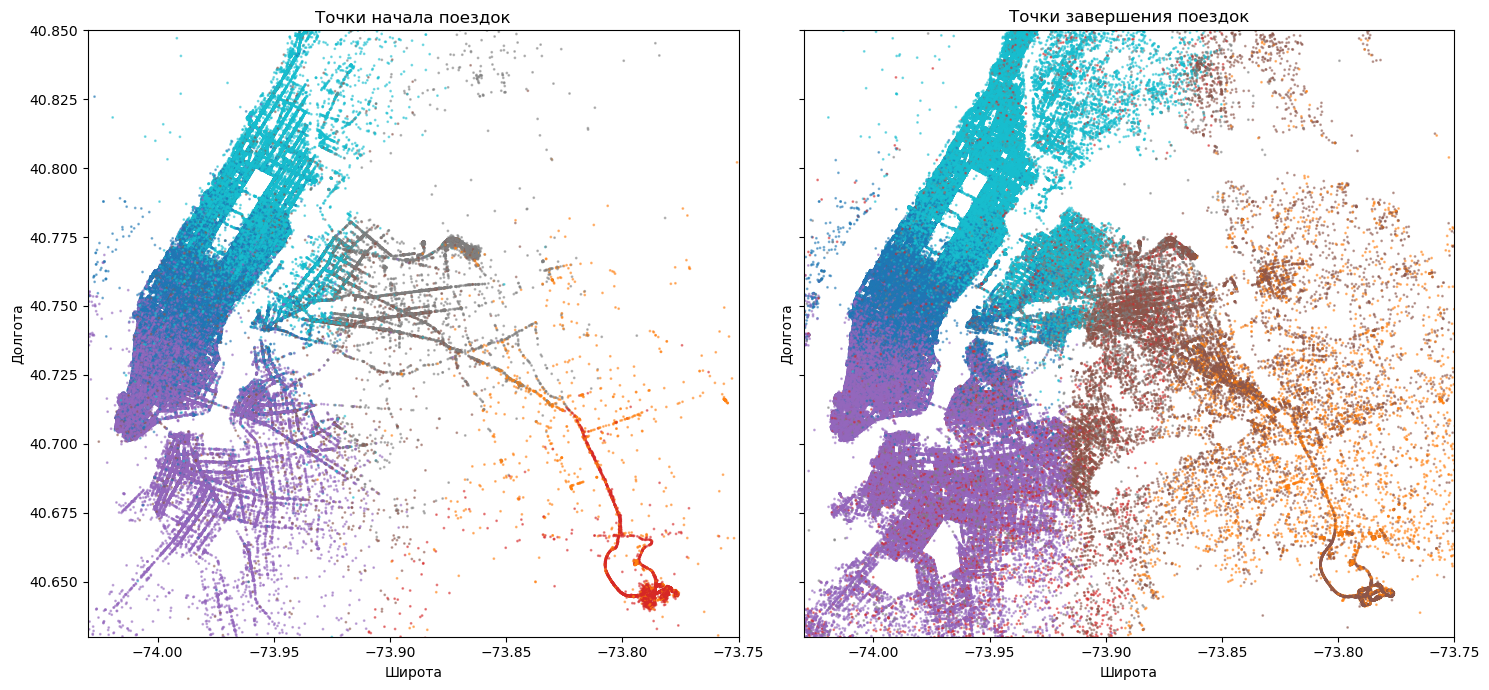

In [35]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 7))

# Строим график точек начала поездок
ax1.scatter(taxi_data['pickup_longitude'], taxi_data['pickup_latitude'], c=taxi_data['geo_cluster'],
            cmap='tab10', s=1, alpha=0.5)

ax1.set_xlabel('Широта')
ax1.set_ylabel('Долгота')
ax1.set_title('Точки начала поездок')
ax1.set_xlim(city_long_border)
ax1.set_ylim(city_lat_border)


# Строим график точек завершения поездок
ax2.scatter(taxi_data['dropoff_longitude'], taxi_data['dropoff_latitude'], c=taxi_data['geo_cluster'], 
            cmap='tab10', s=1, alpha=0.5)

ax2.set_xlabel('Широта')
ax2.set_ylabel('Долгота')
ax2.set_title('Точки завершения поездок')
ax2.set_xlim(city_long_border)
ax2.set_ylim(city_lat_border)


plt.tight_layout()
plt.show()


In [36]:
# Ограничения на границы Нью-Йорка
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Отберем кластеры, находящиеся за границами Нью-Йорка
clusters_outside_nyc = np.setdiff1d(np.unique(taxi_data['geo_cluster']),
                                    np.unique(taxi_data.loc[
                                        (taxi_data['pickup_longitude'] >= city_long_border[0]) &
                                        (taxi_data['pickup_longitude'] <= city_long_border[1]) &
                                        (taxi_data['pickup_latitude'] >= city_lat_border[0]) &
                                        (taxi_data['pickup_latitude'] <= city_lat_border[1]),
                                        'geo_cluster']))

# Количество кластеров, не попавших на диаграммы
num_clusters_outside_nyc = len(clusters_outside_nyc)

print("Количество кластеров, не попавших на диаграммы:", num_clusters_outside_nyc)

Количество кластеров, не попавших на диаграммы: 2


## Часть 3. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [37]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 31)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip',
       'events', 'trip_duration_hours', 'average_speed_kmh',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [38]:
taxi_data = taxi_data.drop(['date', 'hour', 'trip_duration_hours', 'average_speed_kmh'], axis=1)
train_data = taxi_data.copy()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458233 entries, 0 to 1458643
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458233 non-null  object        
 1   vendor_id           1458233 non-null  int64         
 2   pickup_datetime     1458233 non-null  datetime64[ns]
 3   dropoff_datetime    1458233 non-null  object        
 4   passenger_count     1458233 non-null  int64         
 5   pickup_longitude    1458233 non-null  float64       
 6   pickup_latitude     1458233 non-null  float64       
 7   dropoff_longitude   1458233 non-null  float64       
 8   dropoff_latitude    1458233 non-null  float64       
 9   store_and_fwd_flag  1458233 non-null  object        
 10  trip_duration       1458233 non-null  int64         
 11  pickup_date         1458233 non-null  object        
 12  pickup_hour         1458233 non-null  int64         
 13  pickup_day_o

**3.1**
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумаем, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключим выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у нас осталось?


In [39]:
train_data = train_data.drop(['id', 'pickup_datetime'], axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 25)


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [40]:
drop_columns = ['dropoff_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


**3.2**
Закодируем признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 0 в противном случае.

Закодируем признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N",и 1 в противном случае.

а) Рассчитаем среднее по закодированному столбцу vendor_id (округлим с точностью до сотых);

б) Рассчитаем среднее по закодированному столбцу store_and_fwd_flag (округлим с точностью до тысячных).

In [41]:
# Закодируем признак "vendor_id"
train_data['vendor_id'] = train_data['vendor_id'].map(lambda x:0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].map(lambda x:0 if x == 'N' else 1)

print(round(train_data['vendor_id'].mean(), 2))
print(round(train_data['store_and_fwd_flag'].mean(), 3))
train_data.info()

0.53
0.006
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458233 entries, 0 to 1458643
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458233 non-null  int64  
 1   passenger_count     1458233 non-null  int64  
 2   pickup_longitude    1458233 non-null  float64
 3   pickup_latitude     1458233 non-null  float64
 4   dropoff_longitude   1458233 non-null  float64
 5   dropoff_latitude    1458233 non-null  float64
 6   store_and_fwd_flag  1458233 non-null  int64  
 7   trip_duration       1458233 non-null  int64  
 8   pickup_hour         1458233 non-null  int64  
 9   pickup_day_of_week  1458233 non-null  object 
 10  pickup_holiday      1458233 non-null  int64  
 11  total_distance      1458233 non-null  float64
 12  total_travel_time   1458233 non-null  float64
 13  number_of_steps     1458233 non-null  float64
 14  haversine_distance  1458233 non-null  float64
 15  dire

**3.3**
Создадим таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder из библиотеки sklearn. Параметр drop выставим в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder мы получим безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у нас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у нас получилось сгенерировать с помощью однократного кодирования?


In [42]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
one_hot_encoder = preprocessing.OneHotEncoder(drop = 'first')
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray()

# Получим закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)

# Составим DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
#data_onehot.head()
print('Shape of data: {}'.format(data_onehot.shape))
train_data.info()

Shape of data: (1458233, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458233 entries, 0 to 1458643
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458233 non-null  int64  
 1   passenger_count     1458233 non-null  int64  
 2   pickup_longitude    1458233 non-null  float64
 3   pickup_latitude     1458233 non-null  float64
 4   dropoff_longitude   1458233 non-null  float64
 5   dropoff_latitude    1458233 non-null  float64
 6   store_and_fwd_flag  1458233 non-null  int64  
 7   trip_duration       1458233 non-null  int64  
 8   pickup_hour         1458233 non-null  int64  
 9   pickup_day_of_week  1458233 non-null  object 
 10  pickup_holiday      1458233 non-null  int64  
 11  total_distance      1458233 non-null  float64
 12  total_travel_time   1458233 non-null  float64
 13  number_of_steps     1458233 non-null  float64
 14  haversine_distance  1458233 non-null 

Добавим полученную таблицу с закодированными признаками:

In [43]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))
train_data.info()

Shape of data: (1458233, 38)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458233 entries, 0 to 1458232
Data columns (total 38 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   vendor_id                     1458233 non-null  int64  
 1   passenger_count               1458233 non-null  int64  
 2   pickup_longitude              1458233 non-null  float64
 3   pickup_latitude               1458233 non-null  float64
 4   dropoff_longitude             1458233 non-null  float64
 5   dropoff_latitude              1458233 non-null  float64
 6   store_and_fwd_flag            1458233 non-null  int64  
 7   trip_duration                 1458233 non-null  int64  
 8   pickup_hour                   1458233 non-null  int64  
 9   pickup_holiday                1458233 non-null  int64  
 10  total_distance                1458233 non-null  float64
 11  total_travel_time             1458233 non-null  float64
 12 

Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [44]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [45]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


**3.4**
С помощью **SelectKBest** отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуем по обучающей выборке, используя параметр score_func = f_regression.

Укажем признаки, которые вошли в список отобранных.

In [46]:
# ваш код здесь
# Создадим экземпляр SelectKBest
selector = feature_selection.SelectKBest(score_func=f_regression, k=25)

# Применим отбор признаков на обучающей выборке
selector.fit(X_train, y_train_log)
selected_features = selector.get_feature_names_out()
X_train = X_train[selected_features]
X_valid = X_valid[selected_features]

# Выведим список отобранных признаков
print(list(selected_features))

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday', 'total_distance', 'total_travel_time', 'number_of_steps', 'haversine_distance', 'temperature', 'pickup_day_of_week_Monday', 'pickup_day_of_week_Saturday', 'pickup_day_of_week_Sunday', 'pickup_day_of_week_Thursday', 'pickup_day_of_week_Tuesday', 'pickup_day_of_week_Wednesday', 'geo_cluster_1', 'geo_cluster_3', 'geo_cluster_5', 'geo_cluster_7', 'geo_cluster_9']


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


**3.5**
Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитаем среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки (округлим до сотых).


In [47]:
# Создадим экземпляр MinMaxScaler
scaler = preprocessing.MinMaxScaler()

# Обучим нормализатор на обучающей выборке и одновременно преобразуем ее
X_train_scaled = scaler.fit_transform(X_train)

# Преобразуем валидационную выборку с использованием обученного нормализатора
X_valid_scaled = scaler.transform(X_valid)

mean_first_predictor = np.mean(X_valid_scaled[:, 0])

print("Среднее арифметическое для первого предиктора:", round(mean_first_predictor, 2))

Среднее арифметическое для первого предиктора: 0.54


## Часть 4. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



**4.1**
Построим модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе).

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках (округлим до сотых).


In [48]:
# Создадим экземпляр модели линейной регрессии
model = linear_model.LinearRegression()

# Обучим модель на обучающей выборке
model.fit(X_train_scaled, y_train_log)

# Получим предсказания на обучающей выборке
y_train_pred_log = model.predict(X_train_scaled)

# Получим предсказания на валидационной выборке
y_valid_pred_log = model.predict(X_valid_scaled)

# Рассчитаем метрику RMSLE на тренировочной выборке
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log))

# Рассчитаем метрику RMSLE на валидационной выборке
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log))

# Выведим значения метрик
print("RMSLE на тренировочной выборке: {:.2f}".format(rmsle_train))
print("RMSLE на валидационной выборке: {:.2f}".format(rmsle_valid))


RMSLE на тренировочной выборке: 0.54
RMSLE на валидационной выборке: 0.54


**4.2**
Сгенерируем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставим в значение False.

Построим модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе).

а) Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках (округлим до сотых).

б) Наблюдаются ли у нашей модели признаки переобучения?


In [49]:
# Сгенерируем полиномиальные признаки
poly_features = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train_scaled_poly = poly_features.fit_transform(X_train_scaled)
X_valid_scaled_poly = poly_features.fit_transform(X_valid_scaled)

# Создаем и обучаем модель полиномиальной регрессии
poly_model = linear_model.LinearRegression()
poly_model.fit(X_train_scaled_poly, y_train_log)

# Получаем предсказания по нашим выборкам
y_train_pred_log = poly_model.predict(X_train_scaled_poly) 
y_valid_pred_log = poly_model.predict(X_valid_scaled_poly)

# Рассчитаем метрику RMSLE на тренировочной выборке
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log))

# Рассчитаем метрику RMSLE на валидационной выборке
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log))

# Выведим значения метрик
print("RMSLE на тренировочной выборке: {:.2f}".format(rmsle_train))
print("RMSLE на валидационной выборке: {:.2f}".format(rmsle_valid))

RMSLE на тренировочной выборке: 0.47
RMSLE на валидационной выборке: 0.70


**4.3**
Построим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках (округлим до сотых).


In [53]:
# Сгенерируем полиномиальные признаки
poly_features = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train_scaled_poly = poly_features.fit_transform(X_train_scaled)
X_valid_scaled_poly = poly_features.fit_transform(X_valid_scaled)

# Создаем и обучаем модель полиномиальной регрессии с L2-регуляризацией
ridge_model = Ridge(alpha=1)
ridge_model.fit(X_train_scaled_poly, y_train_log)

# Получаем предсказания по нашим выборкам
y_train_pred_log = ridge_model.predict(X_train_scaled_poly) 
y_valid_pred_log = ridge_model.predict(X_valid_scaled_poly)

# Рассчитаем метрику RMSLE на тренировочной выборке
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log))

# Рассчитаем метрику RMSLE на валидационной выборке
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log))

# Выведим значения метрик
print("RMSLE на тренировочной выборке: {:.2f}".format(rmsle_train))
print("RMSLE на валидационной выборке: {:.2f}".format(rmsle_valid))

RMSLE на тренировочной выборке: 0.48
RMSLE на валидационной выборке: 0.48


**4.4**
Построим модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Зададим значение параметра random_state = 42.

а) Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках (округлим до сотых).

б) Наблюдаются ли у нашей модели признаки переобучения?


In [54]:
# Cоздадим модель дерева решений
tree_model = tree.DecisionTreeRegressor(random_state=42)

# Обучим модель на обучающей выборке
tree_model.fit(X_train_scaled, y_train_log)

# Получаем предсказания по нашим выборкам
y_train_pred_log = tree_model.predict(X_train_scaled) 
y_valid_pred_log = tree_model.predict(X_valid_scaled)

# Рассчитаем метрику RMSLE на тренировочной выборке
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log))

# Рассчитаем метрику RMSLE на валидационной выборке
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log))

# Выведим значения метрик
print("RMSLE на тренировочной выборке: {:.2f}".format(rmsle_train))
print("RMSLE на валидационной выборке: {:.2f}".format(rmsle_valid))

RMSLE на тренировочной выборке: 0.00
RMSLE на валидационной выборке: 0.57


**4.5**
Переберем все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Построим линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдем оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? (округлим до сотых).


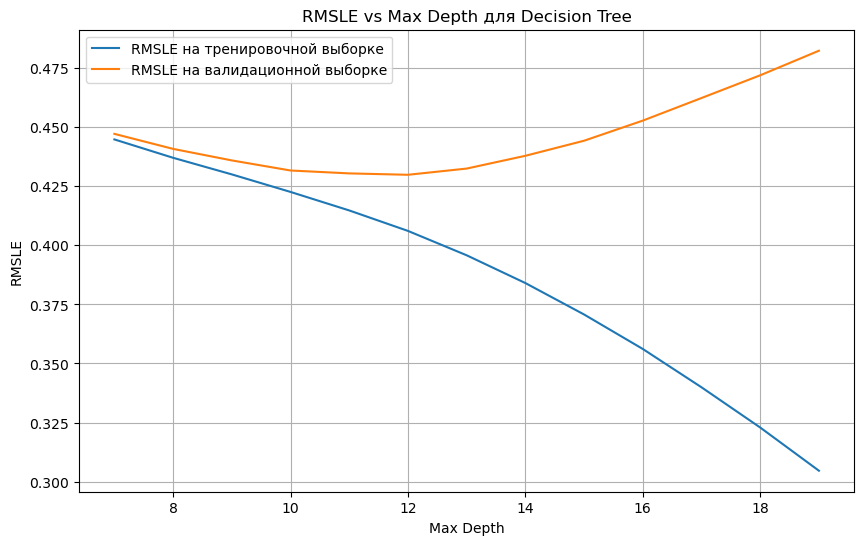

In [55]:
max_depths = range(7,20)
rmsle_train = []
rmsle_valid = []

# Переберем значения глубины дерева
for depth in max_depths:
    # Создадим модель дерева решений
    tree_model = tree.DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    # Обучим модель на обучающей выборке
    tree_model.fit(X_train_scaled, y_train_log)
    
    # Получим предсказания по нашим выборкам
    y_train_pred_log = tree_model.predict(X_train_scaled) 
    y_valid_pred_log = tree_model.predict(X_valid_scaled)
    
   # Рассчитаем метрику RMSLE на тренировочной и валидационной выборке
    rmsle_train = np.append(rmsle_train, np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log)))
    rmsle_valid = np.append(rmsle_valid, np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log)))

# Построим графики
plt.figure(figsize=(10, 6))
plt.plot(max_depths, rmsle_train, label='RMSLE на тренировочной выборке')
plt.plot(max_depths, rmsle_valid, label='RMSLE на валидационной выборке')
plt.xlabel('Max Depth')
plt.ylabel('RMSLE')
plt.title('RMSLE vs Max Depth для Decision Tree')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
# Применим найденную оптимальную глубину дерева
tree_model = tree.DecisionTreeRegressor(max_depth=12)

# Обучим модель на обучающей выборке
tree_model.fit(X_train_scaled, y_train_log)

# Получим предсказания по нашим выборкам
y_train_pred_log = tree_model.predict(X_train_scaled) 
y_valid_pred_log = tree_model.predict(X_valid_scaled)

# Рассчитаем метрику RMSLE на тренировочной выборке
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log))

# Рассчитаем метрику RMSLE на валидационной выборке
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log))

# Выведим значения метрик
print("RMSLE на тренировочной выборке: {:.2f}".format(rmsle_train))
print("RMSLE на валидационной выборке: {:.2f}".format(rmsle_valid))

RMSLE на тренировочной выборке: 0.41
RMSLE на валидационной выборке: 0.43


## Часть 5. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

**5.1**

Построим модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажем следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках (округлим до сотых).


In [57]:
# Создадим модель случайного леса
random_forest_model = ensemble.RandomForestRegressor(n_estimators=200, 
                                                     max_depth=12, 
                                                     criterion='squared_error', 
                                                     min_samples_split=20, 
                                                     random_state=42, 
                                                     verbose=True, 
                                                     n_jobs=-1)

# Обучим модель на обучающей выборке
random_forest_model.fit(X_train_scaled, y_train_log)

# Получим предсказания по нашим выборкам
y_train_pred_log = random_forest_model.predict(X_train_scaled) 
y_valid_pred_log = random_forest_model.predict(X_valid_scaled)

# Рассчитаем метрику RMSLE на тренировочной выборке
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log))

# Рассчитаем метрику RMSLE на валидационной выборке
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log))

# Выведим значения метрик
print("RMSLE на тренировочной выборке: {:.2f}".format(rmsle_train))
print("RMSLE на валидационной выборке: {:.2f}".format(rmsle_valid))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 13.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    2.5s finished


RMSLE на тренировочной выборке: 0.40
RMSLE на валидационной выборке: 0.41


**5.2**
Построим модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). В качестве гиперпараметров укажем следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках (округлим до сотых).


In [58]:
# Создадим модель градиентного бустинга
gradient_boosting_model = ensemble.GradientBoostingRegressor(learning_rate=0.5, 
                                                             n_estimators=100, 
                                                             max_depth=6, 
                                                             min_samples_split=30, 
                                                             random_state=42, 
                                                             verbose=True)

# Обучим модель на обучающей выборке
gradient_boosting_model.fit(X_train_scaled, y_train_log)

# Получим предсказания по нашим выборкам
y_train_pred_log = gradient_boosting_model.predict(X_train_scaled) 
y_valid_pred_log = gradient_boosting_model.predict(X_valid_scaled)

# Рассчитаем метрику RMSLE на тренировочной выборке
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log))

# Рассчитаем метрику RMSLE на валидационной выборке
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log))

# Выведим значения метрик
print("RMSLE на тренировочной выборке: {:.2f}".format(rmsle_train))
print("RMSLE на валидационной выборке: {:.2f}".format(rmsle_valid))

      Iter       Train Loss   Remaining Time 
         1           0.3110           14.17m
         2           0.2247           13.77m
         3           0.1987           13.40m
         4           0.1875           13.16m
         5           0.1821           12.96m
         6           0.1789           12.76m
         7           0.1742           12.61m
         8           0.1721           12.47m
         9           0.1705           12.28m
        10           0.1694           12.16m
        20           0.1585           10.76m
        30           0.1532            9.42m
        40           0.1500            8.16m
        50           0.1468            6.88m
        60           0.1439            5.53m
        70           0.1421            4.12m
        80           0.1402            2.72m
        90           0.1383            1.36m
       100           0.1371            0.00s
RMSLE на тренировочной выборке: 0.37
RMSLE на валидационной выборке: 0.39


**5.3**
Какая из построенных моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


**5.4**
Построим столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажем топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


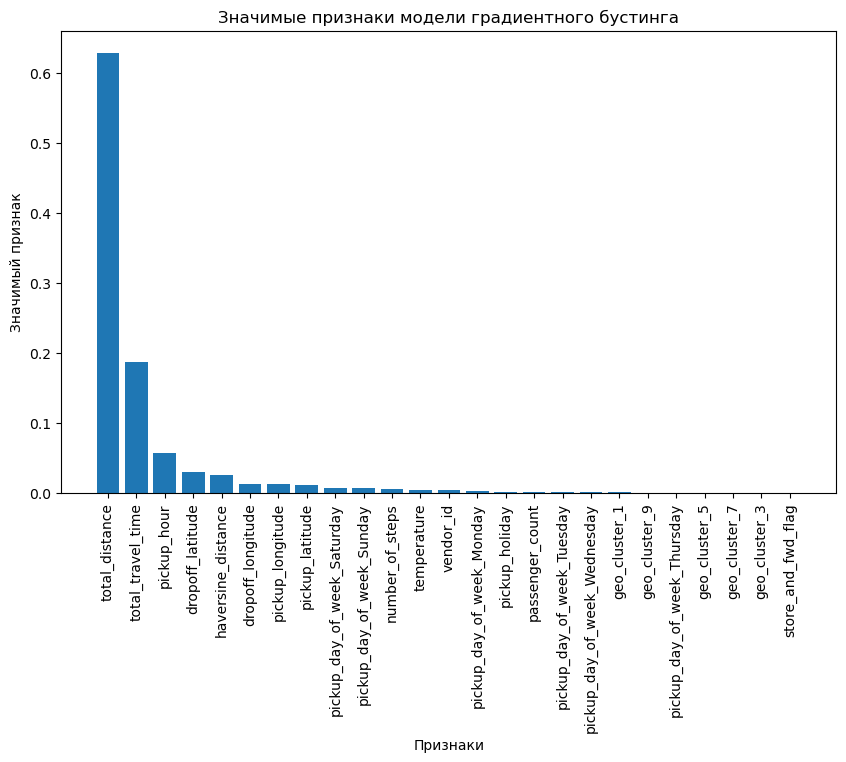

Top 3 признака:
total_distance
total_travel_time
pickup_hour


In [59]:
# Получим коэффициенты значимости каждого из известных факторов
feature_importance = gradient_boosting_model.feature_importances_

# Отсортируем факторы по их значимости
sorted_indices = feature_importance.argsort()[::-1]

# Получим топ-3 наиболее значимых факторов
top3_features = X_train.columns[sorted_indices[:3]]

# Построим столбчатую диаграмму коэффициентов значимости
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_indices])
plt.xticks(range(len(feature_importance)), X_train.columns[sorted_indices], rotation=90)
plt.xlabel('Признаки')
plt.ylabel('Значимый признак')
plt.title('Значимые признаки модели градиентного бустинга')
plt.show()

# Выведем топ-3 наиболее значимых фактора
print('Top 3 признака:')
for feature in top3_features:
    print(feature)

**5.5**
Для лучшей из построенных моделей рассчитем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведем в минуты и округлим до десятых.


In [60]:
# Сделаем перевод из логарифмического масштаба в изначальный
y_valid = np.exp(y_valid_log) - 1

# Сделаем перевод целевой переменной из лог масштаба в изначальный и получим предсказания по валидационной выборке
y_valid_pred = np.exp(gradient_boosting_model.predict(X_valid_scaled)) - 1

# Рассчитаем медианную абсолютную ошибку MeAE
mae = metrics.median_absolute_error(y_valid_pred, y_valid)

# Переведем значение MeAE в минуты
mae = round(mae / 60, 1)

print("MeAE на валидационной выборке:", mae, "мин")

MeAE на валидационной выборке: 1.8 мин


Финальный шаг - сделаем submit -  предсказание для отложенного тестового набора данных.

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:

In [61]:
test_data = pd.read_csv("test_data.csv")
osrm_data_test = pd.read_csv("osrm_data_test.csv")
test_id = test_data['id']

In [62]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  625134 non-null  object 
 1   vendor_id           625134 non-null  int64  
 2   pickup_datetime     625134 non-null  object 
 3   passenger_count     625134 non-null  int64  
 4   pickup_longitude    625134 non-null  float64
 5   pickup_latitude     625134 non-null  float64
 6   dropoff_longitude   625134 non-null  float64
 7   dropoff_latitude    625134 non-null  float64
 8   store_and_fwd_flag  625134 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [63]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, cluster_model)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)

In [64]:
X_test = test_data[selected_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудем перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как мы сформируем предсказание длительности поездок на тестовой выборке нам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:

In [65]:
test_model = gradient_boosting_model
y_test_predict = np.exp(test_model.predict(X_test_scaled)) - 1
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('./submission_gb.csv', index=False)

### **В качестве эксперимента**

Попробуем улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.

Для ее использования необходимо для начала установить пакет xgboost:

In [66]:
pip install xgboost


     ---------------------------------------- 99.8/99.8 MB 4.5 MB/s eta 0:00:00


После чего модуль можно импортировать:

In [67]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [69]:
# Преобразование numpy.ndarray в список строк, если это необходимо
if isinstance(selected_features, np.ndarray):
    selected_features = selected_features.tolist()

# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=selected_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=selected_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=selected_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [70]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
xgb_model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.73992	valid-rmse:0.74194
[10]	train-rmse:0.49093	valid-rmse:0.49351
[20]	train-rmse:0.44059	valid-rmse:0.44344
[30]	train-rmse:0.42595	valid-rmse:0.42899
[40]	train-rmse:0.41826	valid-rmse:0.42145
[50]	train-rmse:0.41278	valid-rmse:0.41628
[60]	train-rmse:0.40921	valid-rmse:0.41297
[70]	train-rmse:0.40578	valid-rmse:0.40984
[80]	train-rmse:0.40266	valid-rmse:0.40697
[90]	train-rmse:0.40070	valid-rmse:0.40529
[100]	train-rmse:0.39897	valid-rmse:0.40397
[110]	train-rmse:0.39740	valid-rmse:0.40265
[120]	train-rmse:0.39626	valid-rmse:0.40178
[130]	train-rmse:0.39502	valid-rmse:0.40086
[140]	train-rmse:0.39424	valid-rmse:0.40034
[150]	train-rmse:0.39301	valid-rmse:0.39936
[160]	train-rmse:0.39220	valid-rmse:0.39888
[170]	train-rmse:0.39146	valid-rmse:0.39832
[180]	train-rmse:0.39072	valid-rmse:0.39789
[190]	train-rmse:0.39009	valid-rmse:0.39756
[200]	train-rmse:0.38924	valid-rmse:0.39706
[210]	train-rmse:0.38877	valid-rmse:0.39680
[220]	train-rmse:0.38794	valid-rmse:0.39626

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [71]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(xgb_model.predict(dtest)) - 1
submission_xgb = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission_xgb.to_csv('./submission_xgb.csv', index=False)
#print('Modeling RMSLE %.5f' % xgb_model.best_score)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

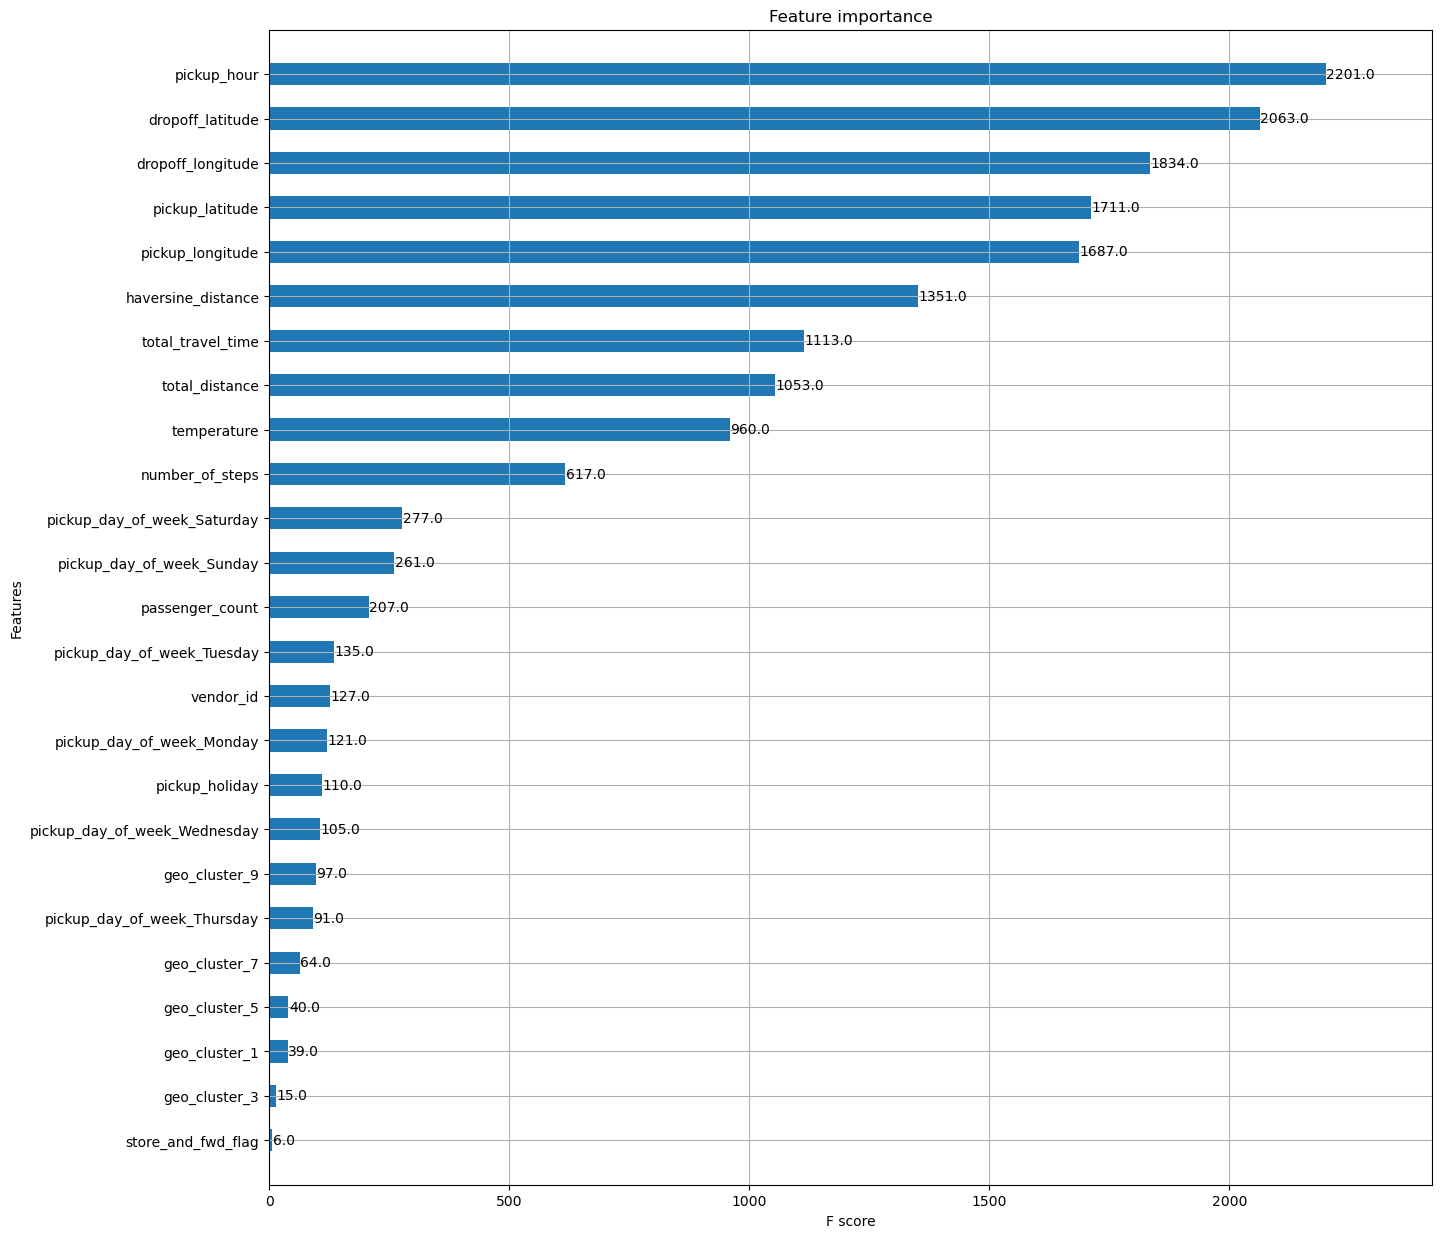

In [72]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(xgb_model, ax = ax, height=0.5)